In [90]:
library(ggplot2)
library(ggExtra)
library(brms)
library(reshape2)
library(coda)
library(tidybayes)
library(ggstance)
library(viridis)
library(latex2exp)
library(ggthemes)
library(data.table)
library(bayesplot)
library(fitdistrplus)
library(bda)
library(arules)

In [91]:
data_path <- "C:/Users/Arkady/Google Drive/data/beyond_the_reach"
table_path <- "C:/Users/Arkady/Dropbox/Research/Journal papers/2018 Beyond the reach/tables"

In [92]:
get_data <- function(data_path, file_name){
    data <- read.table(file.path(data_path, file_name), header = TRUE, sep = "\t")
    data[, 'subj_id'] <- factor(data[, 'subj_id'])  
    data[, 'task'] <- factor(data[, 'task'])  
    data[, 'session'] <- factor(data[, 'session'])  
    data$AUC <- 1 - data$k

    return(data)
}

In [93]:
get_bf_k <- function(data, var, family, rscale, n=1){
    bfs <- data.frame(double(), double(), double())
    
    for (i in 1:n) {
        # sd(var) in this case is 0.5, as var is task (equal number of 0's and 1's)
        priors_task <- c(set_prior(sprintf('normal(%f, %f)', mean(data[, var]), sd(data[, var])), class='Intercept'),
                        set_prior(sprintf('cauchy(0.0, %f)', rscale*sd(data[, var])/0.5), class='b'))

        formula_null <- as.formula(paste(var, "~ (1 | subj_id)"))
        formula_task <- as.formula(paste(var, "~ (1 | subj_id) + task"))
        formula_session <- as.formula(paste(var, "~ (1 | subj_id) + session"))
        formula_inter <- as.formula(paste(var, "~ (1 | subj_id) + task*session"))

        m_null <- brm(formula_null, data=data, family=family, save_all_pars=TRUE, prior=priors_task[1,],
                      refresh=0, control = list(adapt_delta = 0.9, max_treedepth=15))
        m_task <- brm(formula_task, data=data, family=family, save_all_pars=TRUE, prior=priors_task, 
                      refresh=0, control = list(adapt_delta = 0.9, max_treedepth=15))    
        m_session <- brm(formula_session, data=data, family=family, save_all_pars=TRUE, prior=priors_task, 
                      refresh=0, control = list(adapt_delta = 0.9, max_treedepth=15))
        m_inter <- brm(formula_inter, data=data, family=family, save_all_pars=TRUE, prior=priors_task, 
                      refresh=0, control = list(adapt_delta = 0.9, max_treedepth=15))
        
        bf <- t(c(bayes_factor(x1=m_task, x2=m_null)$bf, 
                  bayes_factor(x1=m_session, x2=m_null)$bf, 
                  bayes_factor(x1=m_inter, x2=m_null)$bf))
#         bf_task <- bayes_factor(x1=m_task, x2=m_null)$bf
#         bf_session <- bayes_factor(x1=m_session, x2=m_null)$bf
#         bf_inter <- bayes_factor(x1=m_inter, x2=m_null)$bf

#         names(bf_task) <- 'bf_task'
#         names(bf_session) <- 'bf_session'
#         names(bf_inter) <- 'bf_inter'
        bfs <- rbind(bfs, bf)
    }
    
    colnames(bfs) <- c('bf_task', 'bf_session', 'bf_inter')
    
    # to visualize posteriors, we just use the model fitted last
    result = list(bf=colMeans(bfs),  
                  m_null=m_null, 
                  m_task=m_task, 
                  m_session=m_session,
                  m_inter=m_inter)
    
    return(result)
}

save_posterior <- function(model, file_name){    
    write.csv(as.matrix(as.mcmc(model, combine_chains=TRUE)), 
              file=file.path("posterior_csv", file_name), row.names=FALSE)
}

show_result <- function(result) {
    print("Bayes factors: ")
    print(result$bf)
    hpd_task<-HPDinterval(as.mcmc(result$m_task, combine_chains = TRUE))
    hpd_session<-HPDinterval(as.mcmc(result$m_session, combine_chains = TRUE))
    print("Credible interval for the task effect (walking relative to mouse): ")
    print(hpd_task['b_taskwalking',])
    print("Credible interval for the session effect (2nd session relative to 1st): ")
    print(hpd_session['b_sessionsecond',])
#     mcmc_areas_ridges(as.matrix(as.mcmc(result$m_bias, combine_chains = TRUE)), regex_pars = "b_task", prob=0.95)
}

# Preregistered analysis

In [94]:
data <- get_data(data_path, "k_values_54.csv")
print(nrow(data))

[1] 108


In [95]:
data

subj_id,task,k,session,sequence,SS_bias,AUC
1322,mouse,0.9325057,first,mw,-0.48821750,0.06749429
1402,mouse,0.9703482,first,mw,0.03046794,0.02965183
1408,mouse,0.3983733,second,wm,0.11081885,0.60162671
1474,mouse,0.8751284,first,mw,-0.04696042,0.12487158
1879,mouse,0.8239869,second,wm,-0.27269836,0.17601313
2045,mouse,0.7232734,first,mw,-0.50074000,0.27672660
2249,mouse,0.9584760,first,mw,-0.60422898,0.04152397
2261,mouse,0.8941924,first,mw,-0.57138308,0.10580765
2752,mouse,0.9527112,second,wm,0.14741077,0.04728881
2758,mouse,0.8964184,second,wm,-0.17682609,0.10358162


Contrary to what was assumed at the time of preregistration, k-values aren't approximated well by the normal distribution. Still, we check Bayes factors according to the originally specified design (`gaussian` family parameter in brms)

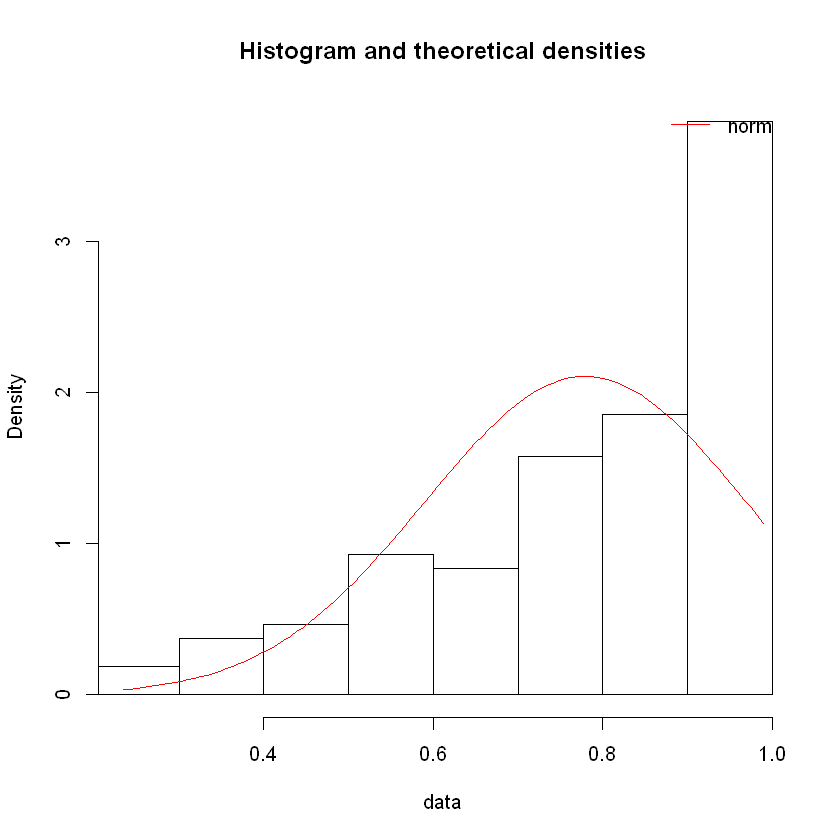

In [96]:
fit_w  <- fitdist(data$k, "norm")
denscomp(fit_w)

In [ ]:
prereg_result <- get_bf_k(data, 'k', gaussian(), 0.707, n=10)

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.329 seconds (Warm-up)
               0.134 seconds (Sampling)
               0.463 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.325 seconds (Warm-up)
               0.136 seconds (Sampling)
               0.461 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.343 seconds (Warm-up)
               0.13 seconds (Sampling)
               0.473 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.347 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.366 seconds (Warm-up)
               0.17 seconds (Sampling)
               0.536 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.396 seconds (Warm-up)
               0.164 seconds (Sampling)
               0.56 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.387 seconds (Warm-up)
               0.172 seconds (Sampling)
               0.559 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.385 seconds (W

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.414 seconds (Warm-up)
               0.221 seconds (Sampling)
               0.635 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.431 seconds (Warm-up)
               0.174 seconds (Sampling)
               0.605 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.432 seconds (Warm-up)
               0.193 seconds (Sampling)
               0.625 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.39 seconds (

Compiling the C++ model


In [ ]:
show_result(prereg_result)

In [ ]:
plot(marginal_effects(prereg_result$m_task))

In [ ]:
save_posterior(prereg_result$m_task, file_name = sprintf("posterior_%s_%s.%s", "k_task", "prereg", "csv"))

# Exploratory analysis

# Accounting for the observed distribution of $k$

After reaching BF>10 in favor of null model over the model with the main effect of task, we terminated data collection, even though BF of the model with the session effect has not yet reached the designated boundary of 10. The reason was that it became evident that there is no difference in discounting behavior between tasks.  Just in case, we checked that this holds if we change the `family` parameter of the brms regression to `weibull`, as Weibull distribution more closely matches the distribution of k-values (we ran the model on zero-peaked quantity `1-k`)

In [ ]:
fit_w  <- fitdist(data$AUC, "weibull")
denscomp(fit_w)

In [ ]:
AUC_weibull_result <- get_bf_k(data, 'AUC', weibull(), 0.707, n=10)

In [ ]:
show_result(AUC_weibull_result)

The Bayes factors in favor of the null model decreased and became less conclusive. We however think that using a modified definition of k-value can help to further clarify whether the task or session afffected k. 

# Using log-delays in calculating k-values

Specifically, as many subjects are close to the head part of the k-value distribution (0.9 to 1.0), we might want to emphasize small differences in discounting curves for these subjects. We can do this by changing the definition of k-value in line with Killeen's additive utility model of delay discounting. Specifically, we use log-scaled delays when calculating k-values (which are recorded to \_log.csv files during preprocessing). 

In [ ]:
log_delay_data <- get_data(data_path, "k_values_54_log.csv")
print(nrow(log_delay_data))

These k-values are more normally distributed

In [ ]:
fit_w  <- fitdist(log_delay_data$k, "norm")
denscomp(fit_w)

In [ ]:
log_delay_result <- get_bf_k(log_delay_data, 'k', gaussian(), 0.707, n=10)

In [ ]:
show_result(log_delay_result)

# Saving results to a table

In [ ]:
save_bf_table <- function(prereg_result, AUC_weibull_result, log_delay_result, caption, label, file_name){
    hyp_2_format_string <- "\\begin{table}[]
                \\centering
                \\sisetup{round-mode=places, round-precision=1, scientific-notation=false}
                \\caption{%s}
                \\label{%s}
                \\begin{tabular}{@{}lll@{}}
                \\toprule
                dependent variable & $\\textrm{M}_{\\textrm{task}}$ & $\\textrm{M}_{\\textrm{session}}$ \\\\ \\midrule
                $k \\sim ~ \\textrm{Gaussian}$ & 1/\\num{%g} & 1/\\num{%g}  \\\\
                $k \\sim ~ \\textrm{Weibull}$ & 1/\\num{%g} & 1/\\num{%g}  \\\\
                $k_{\\log} \\sim ~ \\textrm{Gaussian}$ & 1/\\num{%g} & \\num{%g}\\\\ \\bottomrule
                \\end{tabular}
                \\end{table}"
    
    output <- sprintf(hyp_2_format_string, caption, label, 
                      1/prereg_result$bf[1], 1/prereg_result$bf[2], 
                      1/AUC_weibull_result$bf[1], 1/AUC_weibull_result$bf[2], 
                      1/log_delay_result$bf[1], log_delay_result$bf[2])

    fileConn<-file(file.path(table_path, file_name))
    writeLines(output, fileConn)
    close(fileConn)    
}

caption = "Results of testing Hypothesis 2: Bayes factors of the task-only and session-only models 
        over the null model produced by the preregistered analysis ($k \\sim ~ \\textrm{Gaussian}$) and 
        two exploratory analyses"
label = "tab:hyp_2_bf"
file_name = "hyp_2_bf.tex"

save_bf_table(prereg_result, AUC_weibull_result, log_delay_result, caption, label, file_name)

# Checking the effect of rscale

In [ ]:
get_all_results <- function(rscale){
    prereg_result <- get_bf_k(data, 'k', gaussian(), rscale)
    AUC_Weibull_result <- get_bf_k(data, 'k', weibull(), rscale)
    log_delay_result <- get_bf_k(log_delay_data, 'k', gaussian(), rscale)
    
    result = list(prereg_result=prereg_result,  
                  AUC_Weibull_result=AUC_Weibull_result, 
                  log_delay_result=log_delay_result)
    
    return(result)
}

### Narrower priors (rscale = 0.5)

In [ ]:
narrow_prior_results <- get_all_results(rscale = 0.5)

In [ ]:
show_result(narrow_prior_results$prereg_result)

In [ ]:
show_result(narrow_prior_results$AUC_Weibull_result)

In [ ]:
show_result(narrow_prior_results$log_delay_result)

### Wider priors

In [ ]:
wide_prior_results <- get_all_results(rscale = 1.0)

In [ ]:
show_result(wide_prior_results$prereg_result)

In [ ]:
show_result(wide_prior_results$AUC_Weibull_result)

In [ ]:
show_result(wide_prior_results$log_delay_result)

# Saving everything to RData file

In [ ]:
save.image()